Importing libraries:

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In this notebook, I'll be exploring my data and comparing the counts of words between the two subreddits.

In [2]:
# Reading in the data:

horror = pd.read_csv('./Data/combo.csv')

I'm going to attempt to determine the most common terms/words/topics between the r/nosleep and r/creepypasta subreddit. In the modeling notebook, I'll be testing to see if a model can differentiate between them. I'll also be using this notebook to determine if I have enough data from my grabbing_data notebook, and whether I need more posts to find clearer commonality.

In [3]:
horror.head()

,subreddit,title,selftext
0,nosleep,Biter,"I hope I titled this right, because that's wh..."
1,nosleep,Jacob,"As the new school year approached, my son’s f..."
2,nosleep,The isolation,"\n\nSince I’ve been at home, I’ve been readi..."
3,nosleep,Music Box,"When I was younger, I was super into all thing..."
4,nosleep,A new Instagram influencer is obsessed with me...,Tiffany Fontaine. I loved her name because it ...


Turning my subreddit column into a binary:

In [4]:
horror.subreddit = horror.subreddit.map(dict(nosleep = 1, creepypasta = 0))

In [5]:
horror.head()

,subreddit,title,selftext
0,1,Biter,"I hope I titled this right, because that's wh..."
1,1,Jacob,"As the new school year approached, my son’s f..."
2,1,The isolation,"\n\nSince I’ve been at home, I’ve been readi..."
3,1,Music Box,"When I was younger, I was super into all thing..."
4,1,A new Instagram influencer is obsessed with me...,Tiffany Fontaine. I loved her name because it ...


Pre-processing and cleaning:

In [6]:
horror.isnull().sum()

subreddit    0
title        0
selftext     0
dtype: int64

In [11]:
horror['selftext'] = [text.lower() for text in horror.selftext]

Instantiating CountVectorizer:

In [167]:
cvec = CountVectorizer()

In [168]:
X = horror['selftext']

In [169]:
cvec.fit(X)

CountVectorizer()

In [170]:
X = cvec.transform(X)

Now, I'll turn my data into a dataframe and plot the most commonly occuring words in the reddit posts:

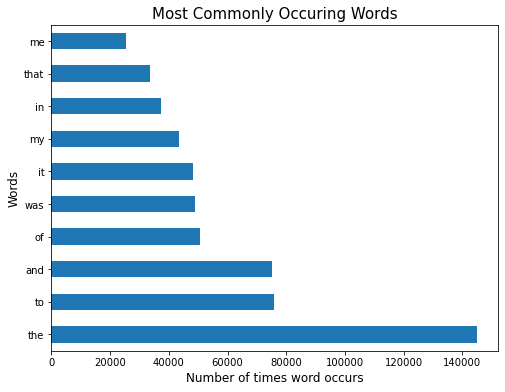

In [171]:
X_df = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names())
                        
X_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (8,6))

plt.title('Most Commonly Occuring Words', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)

plt.savefig('baseline_words.png', bbox_inches = 'tight');

Unsurprisingly, the most common words are small words that should be cleaned out by some sort of stopwords package or a min_df/max_df parameter. I'll try transforming with those parameters next. Mildly interesting to note: "me" and "my" are very common in these posts because most of the stories are written in the first-person perspective.

In [172]:
cvec_2 = CountVectorizer(stop_words = 'english')

Re-defining X to fit to the new model:

In [173]:
X = horror['selftext']

In [174]:
cvec_2.fit(X)

CountVectorizer(stop_words='english')

In [175]:
X = cvec_2.transform(X)

Fitting to a dataframe again and plotting to see the results:

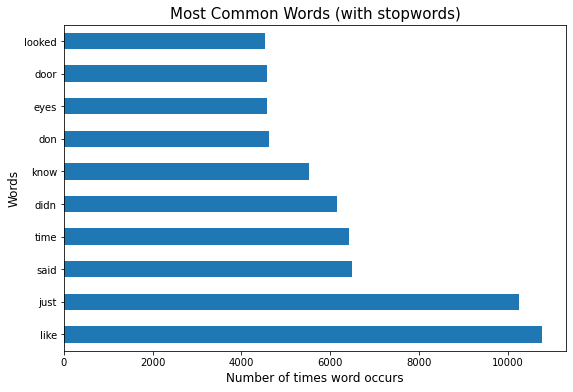

In [176]:
X_df_2 = pd.DataFrame(X.todense(), 
                          columns=cvec_2.get_feature_names())
                        
X_df_2.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (with stopwords)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)

plt.savefig('stopwords_words.png', bbox_inches = 'tight');

Okay, a few more mildly interesting developments: "time", "door", and "eyes" are kind of cool as common horror concepts. They're also our first nouns! However, I don't think the horror novel publisher would be too pleased with this list. It's pretty boring. Time to add more parameters to our CountVectorizer.

In [44]:
X_df_2.shape

(2128, 38042)

That is too many features.

In [177]:
cvec_3 = CountVectorizer(stop_words = 'english', max_df = .50, max_features = 1000)

In [178]:
X = horror['selftext']

In [180]:
cvec_3.fit(X)

CountVectorizer(max_df=0.5, max_features=1000, stop_words='english')

In [181]:
X = cvec_3.transform(X)

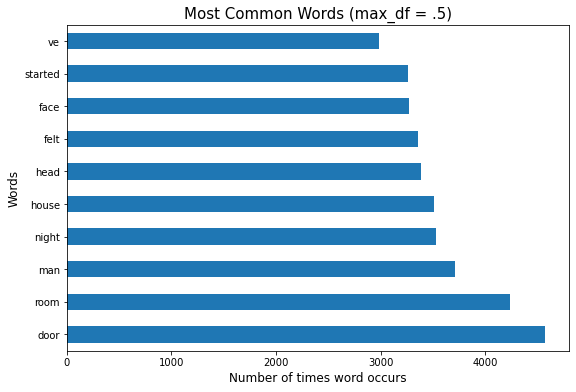

In [182]:
X_df_3 = pd.DataFrame(X.todense(), 
                          columns=cvec_3.get_feature_names())
                        
X_df_3.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .5)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)

plt.savefig('max_df_fifty_words.png', bbox_inches = 'tight');

Well, it took me a few iterations of the max_df parameter, but now we're getting somewhere: "face," "head," "night," "house" - those are definitely closer to "trending horror topics." Let's skim a bit further and see what we find.

In [183]:
cvec_4 = CountVectorizer(stop_words = 'english', max_df = .25, max_features = 1000)

In [184]:
X = horror['selftext']

In [185]:
cvec_4.fit(X)

CountVectorizer(max_df=0.25, max_features=1000, stop_words='english')

In [186]:
X = cvec_4.transform(X)

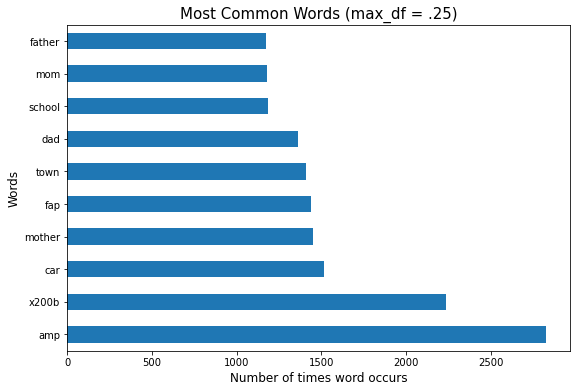

In [187]:
X_df_4 = pd.DataFrame(X.todense(), 
                          columns=cvec_4.get_feature_names())
                        
X_df_4.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .25)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)

plt.savefig('max_df_25_words.png', bbox_inches = 'tight');

Okay, so there's definitely a parent theme going on here. That could certainly be of note to the publisher - "recent horror stories on r/nosleep and r/creepypasta very frequently contain themes relating to parents." Let's go a little deeper:

In [190]:
cvec_5 = CountVectorizer(stop_words = 'english', max_df = .15, max_features = 1000)

In [191]:
X = horror['selftext']

In [192]:
cvec_5.fit(X)

CountVectorizer(max_df=0.15, max_features=1000, stop_words='english')

In [193]:
X = cvec_5.transform(X)

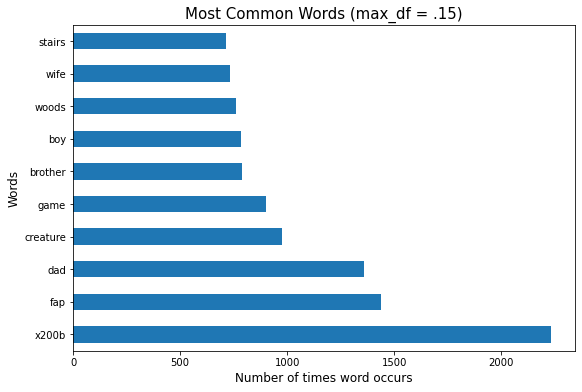

In [194]:
X_df_5 = pd.DataFrame(X.todense(), 
                          columns=cvec_5.get_feature_names())
                        
X_df_5.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .15)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.savefig('max_df_15_words.png', bbox_inches = 'tight');

Now, we're really getting down to it. "Game" is especially interesting to me - a few recent horror movies have been based around games (Truth or Dare (2018), Ready or Not (2019)). One of the most famous horror film series of the last decade, the Saw films, sees its main antagonist telling victims, "I want to play a game." "Game" as a common, trending topic in recent self-published horror stories is very significant to me. "Creature" and "woods" are also important to note. Going even a little more specific:

In [195]:
cvec_6 = CountVectorizer(stop_words = 'english', max_df = .1, max_features = 1000)

In [196]:
X = horror['selftext']

In [197]:
cvec_6.fit(X)

CountVectorizer(max_df=0.1, max_features=1000, stop_words='english')

In [198]:
X = cvec_6.transform(X)

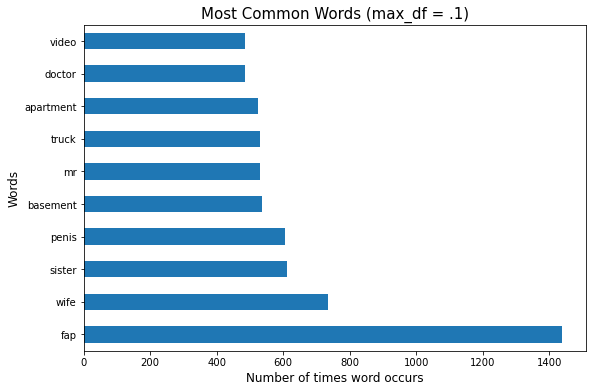

In [199]:
X_df_6 = pd.DataFrame(X.todense(), 
                          columns=cvec_6.get_feature_names())
                        
X_df_6.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .1)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.savefig('max_df_10_words.png', bbox_inches = 'tight');

Blatantly ignoring some of the more X-rated topics here, we have some very interesting developments: "basement," "truck," "doctor," and "video." "Video" has been a popular topic in horror films and books since the invention of the VHS format, but it became even more popular after 2002's The Ring (a remake of 1998's Ringu (Japanese), itself an adaptation of Koji Suzuki's 1991 novel of the same name), one of the most popular and well-known horror movies of the 21st century.

Of course, denying the existence of the more explicit topics can't be done forever - it is important for the horror publisher to know that many members of their audience are interested in more Adult content in general.

Let's just refine it even more:

In [146]:
cvec_7 = CountVectorizer(stop_words = 'english', max_df = .05, max_features = 1000)

In [147]:
X = horror['selftext']

In [148]:
cvec_7.fit(X)

CountVectorizer(max_df=0.05, max_features=1000, stop_words='english')

In [149]:
X = cvec_7.transform(X)

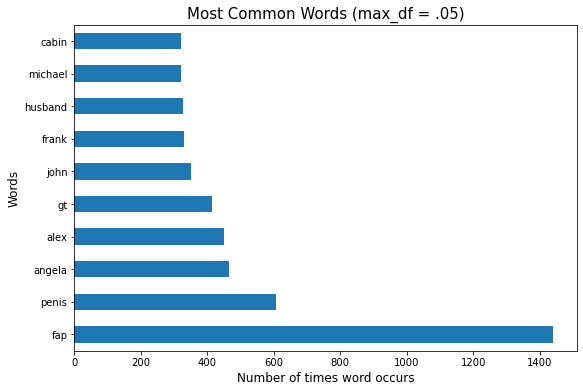

In [150]:
X_df_7 = pd.DataFrame(X.todense(), 
                          columns=cvec_7.get_feature_names())
                        
X_df_7.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .05)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12);

Okay, so a max_df of .05 is maybe a little bit too specific, and we can see that we've turned to commonly-used first names. However, we've also come up with "cabin," which I think is useful - cabins are an important trope in the horror genre, as they usually bring along a sense of isolation that can contribute to the story. Many successful horror media items have been based entirely in cabins, including the 2002 film Cabin Fever, the 2011 film Cabin in the Woods (a subversion of the trope and the genre as a whole), and Paul Tremblay's 2018 postapocalyptiv horror novel, The Cabin at the End of the World.

Also interesting to note that all of these refinements of the transformer model, "wife"/"mother" have been included in more stories than "husband"/"father" (except for "brother" being indluded in more than "sister," which is interesting), which likely speaks more to the demograohic writing (and, therefore, reading) these stories than anything else.

For my last simple transformer, I'm going to go back to a higher max_df but also include n-grams, just to see if there are any interesting combinations of two words that are common.

In [151]:
cvec_8 = CountVectorizer(stop_words = 'english', max_df = .15, max_features = 1000,
                        ngram_range = (1,2))

In [152]:
X = horror['selftext']

In [153]:
cvec_8.fit(X)

CountVectorizer(max_df=0.15, max_features=1000, ngram_range=(1, 2),
                stop_words='english')

In [154]:
X = cvec_8.transform(X)

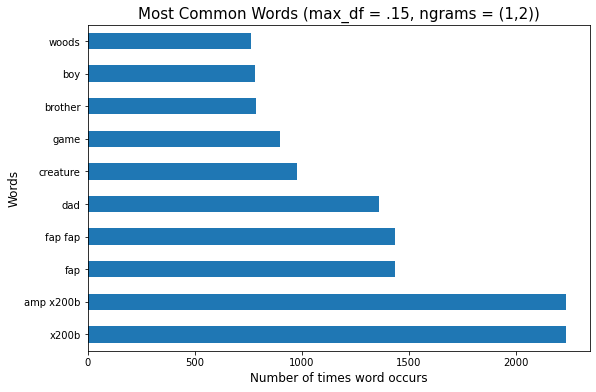

In [155]:
X_df_8 = pd.DataFrame(X.todense(), 
                          columns=cvec_8.get_feature_names())
                        
X_df_8.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .15, ngrams = (1,2))', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12);

Well. Let's just up the max_df and see if we get anything interesting there. I'm also going to define a new stopwords list that will count out 'amp' and 'x200b,' which are apparently, when used together, a method for creating white space in a reddit post.

In [223]:
words = ['amp', 'x200b']

In [218]:
cvec_9 = CountVectorizer(stop_words = words, max_df = .35, max_features = 1000,
                        ngram_range = (1,2))

In [219]:
X = horror['selftext']

In [220]:
cvec_9.fit(X)

CountVectorizer(max_df=0.35, max_features=1000, ngram_range=(1, 2),
                stop_words=['amp', 'x200b'])

In [221]:
X = cvec_9.transform(X)

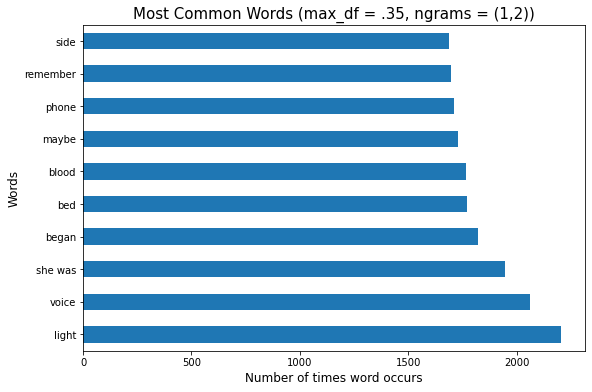

In [222]:
X_df_9 = pd.DataFrame(X.todense(), 
                          columns=cvec_9.get_feature_names())
                        
X_df_9.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .35, ngrams = (1,2))', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.savefig('max_df_35_words.png', bbox_inches = 'tight');

Ooh, we have some very interesting developments here that we may have missed by not doing max_df = .35 before. Not so interesting on the n-gram front, but we now have "light," "bed," "blood," and my favorite, "phone." Phones are tricky things in the horror universe: they're a connection, but a distant one. The person on the other end of the line can't help you if you're in a dire situation. On the other hand, you never really know where the caller is, so they may be closer than you think - thus the famous "the call is coming from inside the house" story, and the iconic opening sequence of the 1996 film Scream. 

I also love "light" as a common topic, because while the trope may be that turning on the light can save you from what lurks in the dark, how much scarier are horrific things done in broad daylight? Case in point: the 2019 A24 film Midsommar, otherwise known as the lightest, brightest horror movie I've ever seen.

Let's try one more, setting the max_df to .30, which we haven't tried before, because I'm getting the impression that .25 - .4 is the sweet spot for interesting topics.

In [212]:
cvec_10 = CountVectorizer(stop_words = words, max_df = .3, max_features = 1000)

In [213]:
X = horror['selftext']

In [214]:
cvec_10.fit(X)

CountVectorizer(max_df=0.3, max_features=1000, stop_words=['amp', 'x200b'])

In [215]:
X = cvec_10.transform(X)

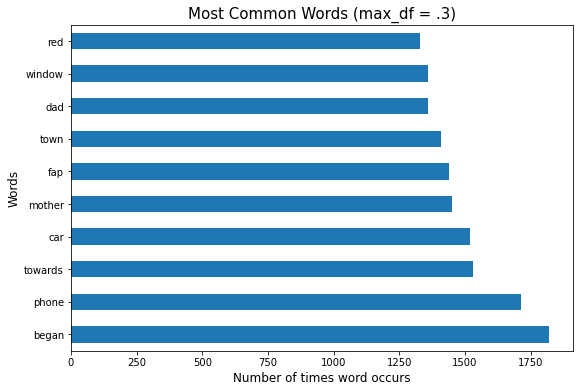

In [217]:
X_df_10 = pd.DataFrame(X.todense(), 
                          columns=cvec_10.get_feature_names())
                        
X_df_10.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', figsize = (9,6))

plt.title('Most Common Words (max_df = .3)', fontsize = 15)

plt.xlabel('Number of times word occurs', fontsize = 12)
plt.ylabel('Words', fontsize = 12);

Okay, so most of these we've seen before, but I do love "window" as a new concept (similar to the phone, it  projects an impression of safety because it seems like a barrier, but is easily broken or creepily stared-through by something unwanted). We're also back to "mother" and "dad," so Freud would dine out for weeks on this.

Looking over this notebook, it appears that our most common (interesting) topics that we can report to the publisher are "game," "cabin," "video," "woods," "creature," "phone," "light," a strong parental theme, and a trend towards rather "adult" topics.